# **CAMNS** implementation

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from skimage.io import imread

In [2]:
def is_ext_pt(C, d, alpha, tol):
    L, D = C.shape
    T = C[np.all(np.abs(C.dot(alpha) + d) < tol, axis=1), :]
    u, s, vh = np.linalg.svd(T)
    rank = sum(s / np.sum(s) > tol)
    return rank == D

In [3]:
def CAMNS(X, N):
    tol_lp = 1e-3
    tol_ext = 1e-6
    tol_zeros = 1e-6
    
    X = X.T
    L, M = X.shape
    d = np.mean(X, axis=1, keepdims=True)
    C, s, vh = np.linalg.svd(X - d, full_matrices=False)
    el = 0
    B = np.eye(L)
    hS = np.zeros((0, L))
    C = C[:, :N-1]

    while el < N:
        w = np.random.uniform(size=L)
        r = B.dot(w)
        alpha1 = np.array(solvers.conelp(matrix(-C.T.dot(r)), matrix(-C), matrix(d), 
                                         options={'show_progress': False})['x'])
        alpha2 = np.array(solvers.conelp(-matrix(-C.T.dot(r)), matrix(-C), matrix(d), 
                                         options={'show_progress': False})['x'])
        if el == 0:
            if is_ext_pt(C, d, alpha1, tol=tol_ext):
                hS = np.append(hS, [(C.dot(alpha1) + d).squeeze()], axis=0)

            if is_ext_pt(C, d, alpha2, tol=tol_ext):
                hS = np.append(hS, [(C.dot(alpha2) + d).squeeze()], axis=0)

        else:
            pstar = np.abs(r.T.dot(C.dot(alpha1) + d))
            qstar = np.abs(r.T.dot(C.dot(alpha2) + d))
            if not np.allclose(pstar, 0, rtol=tol_lp):
                if is_ext_pt(C, d, alpha1, tol=tol_ext):
                    hS = np.append(hS, [(C.dot(alpha1) + d).squeeze()], axis=0)

            if not np.allclose(qstar, 0, rtol=tol_lp):
                if is_ext_pt(C, d, alpha2, tol=tol_ext):
                    hS = np.append(hS, [(C.dot(alpha2) + d).squeeze()], axis=0)

        el = hS.shape[0]
        Q, R = np.linalg.qr(hS.T)
        B = np.eye(L) - Q.dot(Q.T)
    return hS

Рассмотрим на примере вот таких картинок:

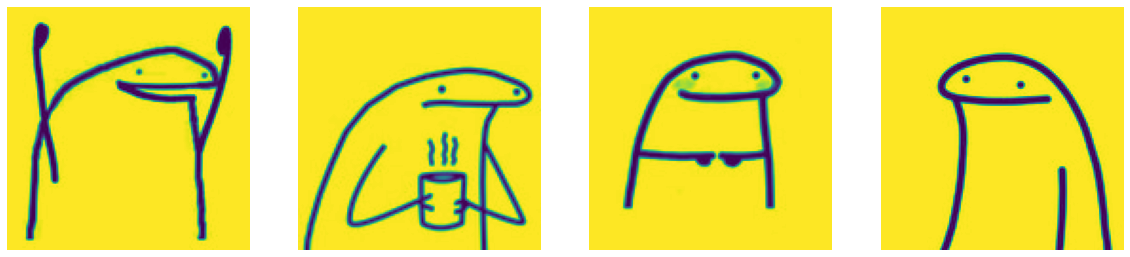

In [10]:
images = []
images_finalized = []
images.append(imread("dovolniy.jpg"))
images.append(imread("piet_chay.jpg"))
images.append(imread("stesnyaetsya.jpg"))
images.append(imread("prosto_stoit.jpg"))
for image in images:
    if len(image.shape) > 2:
        image = np.delete(image, range(1, image.shape[2]), axis=2)
    image = image / 255
    size = image.shape[0]
    image = image.reshape(size ** 2)
    images_finalized.append(image)


figure, axes = plt.subplots(1, len(images_finalized), figsize=(20, 5))
for i, image in enumerate(images_finalized):
    image = image.reshape(size, size)
    axes[i].imshow(image)
    axes[i].axis('off')

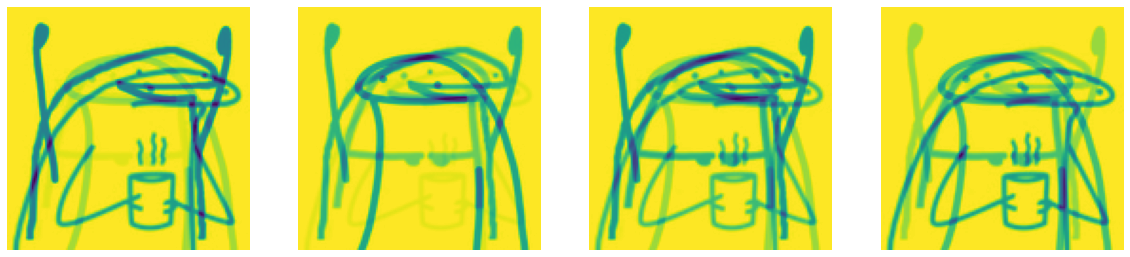

In [11]:
images_count = len(images_finalized)
M = np.random.rand(images_count, images_count)
images_mixed = (M / np.sum(M, axis=1, keepdims=True)).dot(images_finalized)

figure, axes = plt.subplots(1, len(images_mixed), figsize=(20, 5))
for i, image in enumerate(images_mixed):
    image = image.reshape(128, 128)
    axes[i].imshow(image,)
    axes[i].axis('off')

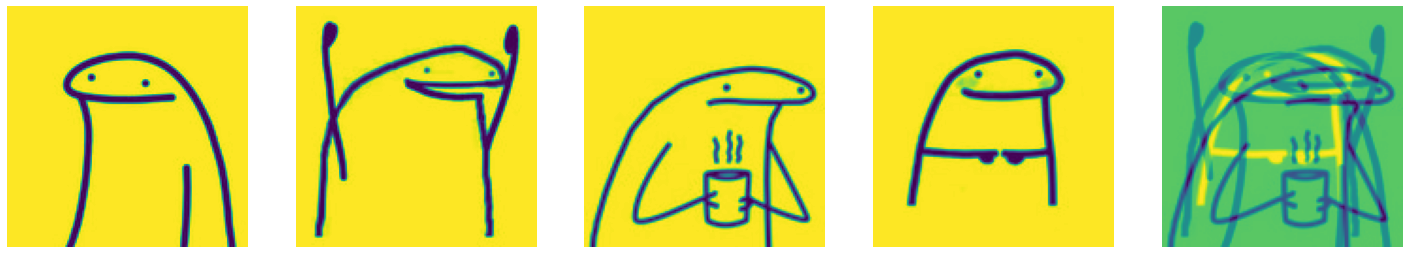

In [12]:
images_fixed = CAMNS(images_mixed, images_count)
figure, axes = plt.subplots(1, len(images_fixed), figsize=(5 * len(images_fixed), 5))
    
for i, image in enumerate(images_fixed):
    image = image.reshape(size, size)
    axes[i].imshow(image)
    axes[i].axis('off')

Получили отличный результат, картинки прекрасно разделились, однако "бонусом" получили лишнюю картинку. Попробуем на другом наборе:

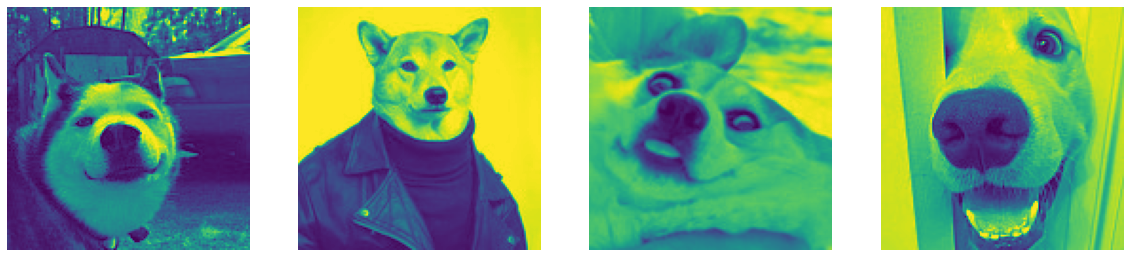

In [4]:
images = []
images_finalized = []
images.append(imread("ulibaetsya.jpg"))
images.append(imread("bandit.jpg"))
images.append(imread("plavleniy.jpg"))
images.append(imread("privet.jpg"))
for image in images:
    if len(image.shape) > 2:
        image = np.delete(image, range(1, image.shape[2]), axis=2)
    image = image / 255
    size = image.shape[0]
    image = image.reshape(size ** 2)
    images_finalized.append(image)


figure, axes = plt.subplots(1, len(images_finalized), figsize=(20, 5))
for i, image in enumerate(images_finalized):
    image = image.reshape(size, size)
    axes[i].imshow(image)
    axes[i].axis('off')

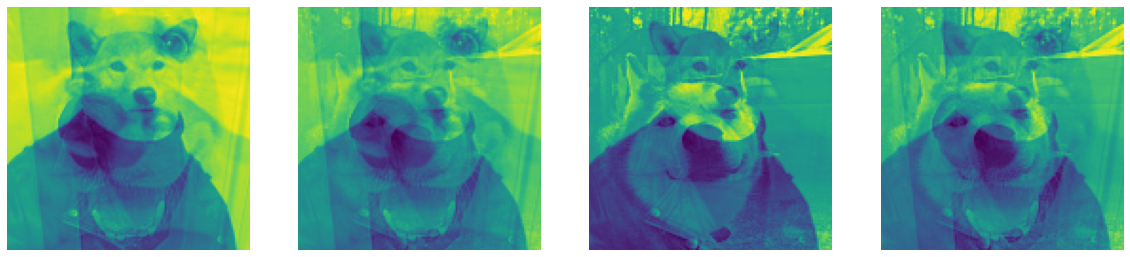

In [5]:
images_count = len(images_finalized)
M = np.random.rand(images_count, images_count)
images_mixed = (M / np.sum(M, axis=1, keepdims=True)).dot(images_finalized)

figure, axes = plt.subplots(1, len(images_mixed), figsize=(20, 5))
for i, image in enumerate(images_mixed):
    image = image.reshape(size, size)
    axes[i].imshow(image)
    axes[i].axis('off')

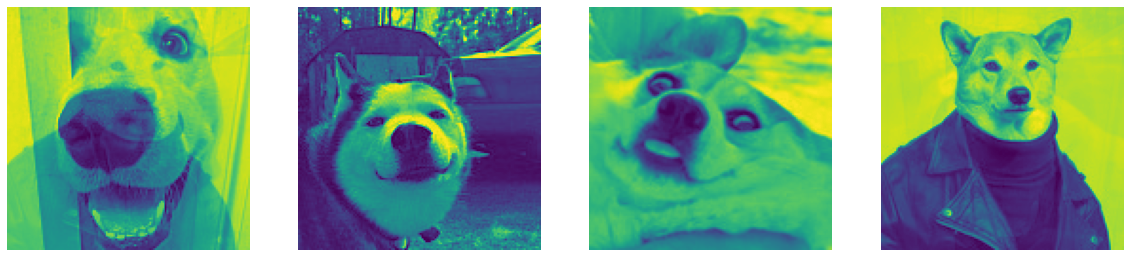

In [6]:
images_fixed = CAMNS(images_mixed, images_count)
figure, axes = plt.subplots(1, len(images_fixed), figsize=(5 * len(images_fixed), 5))
    
for i, image in enumerate(images_fixed):
    image = image.reshape(size, size)
    axes[i].imshow(image)
    axes[i].axis('off')

Видим, что результат в целом тоже хороший, однако картинки 1 и 4 остались немного смешанными, возможно, из-за того, что они в целом похожи - однотонный фон и темные детали в нижней части. Картинки 2 и 3 восстановились хорошо.